In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from retirement_engine.withdrawal_strategies import pause_after_loss_withdrawal, guardrails_withdrawal, fixed_withdrawal, dynamic_percent_withdrawal, cola_adjusted_withdrawal, inflation_adjusted_withdrawal, cola_guardrails_withdrawal

In [27]:

class RetirementSimulator:

    STRATEGIES = {
        "Pause After Loss": pause_after_loss_withdrawal,
        "Guardrails": guardrails_withdrawal,
        "Fixed": fixed_withdrawal,
        "Dynamic": dynamic_percent_withdrawal,
        "Inflation Adjusted": inflation_adjusted_withdrawal,
        "COLA Adjusted": cola_adjusted_withdrawal,
        "COLA + Guardrails": cola_guardrails_withdrawal,
    }

    STRATEGY_META = {
        "Fixed": {
            "needs": ["balance_series", "withdrawal_rate", "initial_balance"]
        },
        "Guardrails": {
            "needs": ["balance_series", "withdrawal_rate", "initial_balance"]
        },
        "Dynamic": {
            "needs": ["balance_series", "withdrawal_rate", "initial_balance"]
        },
        "Pause After Loss": {
            "needs": ["balance_series", "return_windows", "withdrawal_rate", "sp500_weight"]
        },
        "Inflation Adjusted": {
            "needs": ["initial_balance", "withdrawal_rate", "return_series","sp500_weight"]
        },
        "COLA Adjusted": {
            "needs": ["initial_balance","withdrawal_rate","inflation_windows"]
        },
        "COLA + Guardrails":{
            "needs":["initial_balance", "withdrawal_rate", "inflation_windows", "balance_series"]
        }
    }

    def __init__(
        self,
        returns,
        strategy,
        withdrawal_rate,
        initial_balance=1_000_000,
        sp500_weight=0.6,
        days_per_year=252,
        inflation_adjust=True,  # ← Add this line
        inflation_windows=None  # ← Already present if you're using it
    ):
        self.returns = returns
        self.strategy = strategy
        self.withdrawal_rate = withdrawal_rate
        self.initial_balance = initial_balance
        self.sp500_weight = sp500_weight
        self.days_per_year = days_per_year
        self.inflation_adjust = inflation_adjust  # ← Add this line
        self.inflation_windows = inflation_windows or []

        self.balance_series = []
        self.return_windows = []
        self.withdrawals = []
        self.balances = []

    def compute_blended_return(self, sp500_r, bonds_r, inflation_r=0.0):
        try:
            blended = self.sp500_weight * float(sp500_r) + (1 - self.sp500_weight) * float(bonds_r)
            if self.inflation_adjust:
                blended -= float(inflation_r)
            if not isinstance(blended, (int, float)) or blended == float("inf") or blended != blended:
                raise ValueError("Invalid blended return")
            return blended
        except Exception as e:
            print(f"[ERROR] Failed to compute blended return → {sp500_r, bonds_r, inflation_r} → {e}")
            return 0.0

    def simulate_market(self):
        self.balance_series = []
        self.return_windows = []
        self.inflation_windows = []
        self.return_series = []

        balance = self.initial_balance

        for day in range(len(self.returns)):
            try:
                sp500_r, bonds_r, inflation_r = self.returns[day]
            except ValueError:
                # Fallback for non-inflation tuples
                sp500_r, bonds_r = self.returns[day]
                inflation_r = 0.0

            blended_r = self.compute_blended_return(sp500_r, bonds_r, inflation_r)
            balance *= 1 + blended_r

            self.return_series.append((sp500_r, bonds_r))  # ← This is what was missing


            if day % self.days_per_year == 0:
                self.balance_series.append(balance)

                trailing_returns = self.returns[max(0, day - self.days_per_year):day]
                self.return_windows.append(trailing_returns)

                trailing_inflation = [r[2] if len(r) > 2 else 0.0 for r in trailing_returns]
                self.inflation_windows.append(trailing_inflation)

    def apply_strategy(self):
        if self.strategy not in self.STRATEGIES:
            raise NotImplementedError(f"Strategy '{self.strategy}' not implemented")

        strategy_fn = self.STRATEGIES[self.strategy]
        required_args = self.STRATEGY_META[self.strategy]["needs"]

        args = []
        for arg_name in required_args:
            if not hasattr(self, arg_name):
                raise ValueError(f"[ERROR] Missing required input: {arg_name} for strategy '{self.strategy}'")
            args.append(getattr(self, arg_name))

        self.withdrawals = strategy_fn(*args)


    def reconstruct_balances(self):
        balance = self.initial_balance
        year_index = 0
        for day in range(len(self.returns)):
            if day % self.days_per_year == 0 and year_index < len(self.withdrawals):
                balance -= self.withdrawals[year_index]
                year_index += 1

            sp500_r, bonds_r, _ = self.returns[day]
            blended_r = self.compute_blended_return(sp500_r, bonds_r)
            balance *= 1 + blended_r
            self.balances.append(balance)

    def run(self):
        self.simulate_market()
        self.apply_strategy()
        self.reconstruct_balances()
        return self.balances, self.withdrawals

In [28]:
def load_market_data(path, sp500_weight=0.6):
    df = pd.read_csv(path)
    df["SP500_return"] = df["SP500"].pct_change()
    df["BONDS_return"] = df["BONDS"].pct_change()
    df = df.dropna()
    return list(zip(df["SP500_return"], df["BONDS_return"]))

In [29]:
def generate_synthetic_inflation(days, annual_rate=0.02):
    daily_rate = (1 + annual_rate) ** (1 / 252) - 1
    return [daily_rate] * days

In [30]:
base_returns = load_market_data("data/market.csv")
inflation_series = generate_synthetic_inflation(len(base_returns))

returns = [(sp500_r, bonds_r, infl_r) for ((sp500_r, bonds_r), infl_r) in zip(base_returns, inflation_series)]

In [31]:

df_returns = pd.DataFrame(returns, columns=["SP500", "Bonds", "Inflation"])
print(df_returns.head())

      SP500     Bonds  Inflation
0  0.048715 -0.013211   0.000079
1  0.013033  0.001228   0.000079
2  0.002419  0.012390   0.000079
3 -0.026108  0.005695   0.000079
4 -0.022415  0.010241   0.000079


In [32]:
sim = RetirementSimulator(
    returns=returns,
    strategy="Inflation Adjusted",
    withdrawal_rate=0.04,
    initial_balance=1_000_000,
    sp500_weight=0.6
)

balances, withdrawals = sim.run()
print(f"Final Balance: ${balances[-1]:,.2f}")
print(f"Total Withdrawn: ${sum(withdrawals):,.2f}")


Final Balance: $1,940,793.37
Total Withdrawn: $1,023,909.38


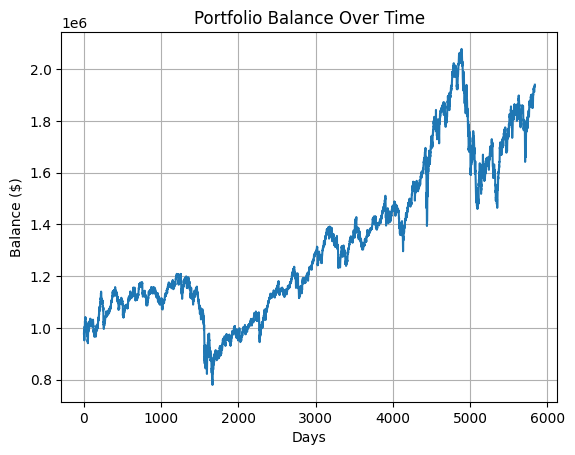

In [33]:

plt.plot(balances)
plt.title("Portfolio Balance Over Time")
plt.xlabel("Days")
plt.ylabel("Balance ($)")
plt.grid(True)
plt.show()

In [34]:
sim = RetirementSimulator(
    returns=returns,
    strategy="COLA Adjusted",
    withdrawal_rate=0.04,
    initial_balance=1_000_000,
    inflation_adjust=True
)

balances, withdrawals = sim.run()
print(f"Final Balance: ${balances[-1]:,.2f}")
print(f"Total Withdrawn: ${sum(withdrawals):,.2f}")

Final Balance: $1,653,098.60
Total Withdrawn: $1,216,874.50


In [35]:
def annual_blended_returns(return_series, sp500_weight, days_per_year=252):
    annual_returns = []
    for i in range(0, len(return_series), days_per_year):
        year_chunk = return_series[i : i + days_per_year]
        cumulative = 1.0
        for sp500_r, bonds_r in year_chunk:
            blended_r = sp500_weight * sp500_r + (1 - sp500_weight) * bonds_r
            cumulative *= 1 + blended_r
        annual_returns.append(cumulative - 1)
    return annual_returns

In [36]:
# Run COLA + Guardrails strategy
sim = RetirementSimulator(
    returns=returns,
    strategy="COLA + Guardrails",
    withdrawal_rate=0.04,
    initial_balance=1_000_000,
    inflation_adjust=True
)

balances, withdrawals = sim.run()

print(f"Final Balance: ${balances[-1]:,.2f}")
print(f"Total Withdrawn: ${sum(withdrawals):,.2f}")
print(f"Withdrawals (first 5): {[round(w, 2) for w in withdrawals[:5]]}")

Year 1: COLA = 40000.00, Cap = 62898.12
Year 2: COLA = 40800.00, Cap = 71303.14
Year 3: COLA = 41616.00, Cap = 78696.84
Year 4: COLA = 42448.32, Cap = 96377.09
Year 5: COLA = 43297.29, Cap = 89249.87
Year 6: COLA = 44163.23, Cap = 102555.22
Year 7: COLA = 45046.50, Cap = 88908.91
Year 8: COLA = 45947.43, Cap = 68662.17
Year 9: COLA = 46866.38, Cap = 81853.98
Year 10: COLA = 47803.70, Cap = 94725.63
Year 11: COLA = 48759.78, Cap = 128903.46
Year 12: COLA = 49734.97, Cap = 136364.75
Year 13: COLA = 50729.67, Cap = 163049.16
Year 14: COLA = 51744.27, Cap = 186772.14
Year 15: COLA = 52779.15, Cap = 206486.69
Year 16: COLA = 53834.73, Cap = 216704.20
Year 17: COLA = 54911.43, Cap = 236251.81
Year 18: COLA = 56009.66, Cap = 262004.83
Year 19: COLA = 57129.85, Cap = 150549.79
Year 20: COLA = 58272.45, Cap = 167312.92
Year 21: COLA = 59437.90, Cap = 352951.90
Year 22: COLA = 60626.65, Cap = 319121.93
Year 23: COLA = 61839.19, Cap = 367048.72
Year 24: COLA = 63075.97, Cap = 159419.04
Final Bala

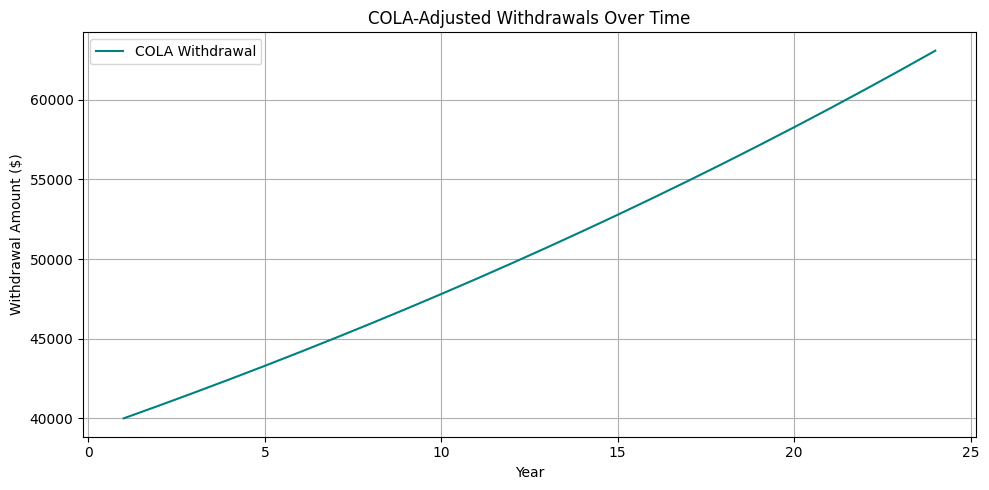

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Rebuild COLA-adjusted withdrawals
cola_withdrawals = cola_adjusted_withdrawal(
    initial_balance=1_000_000,
    rate=0.04,
    inflation_windows=sim.inflation_windows
)

# Create DataFrame
df_cola = pd.DataFrame({
    "Year": list(range(1, len(cola_withdrawals) + 1)),
    "COLA_Adjusted_Withdrawal": cola_withdrawals
})

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df_cola["Year"], df_cola["COLA_Adjusted_Withdrawal"], label="COLA Withdrawal", color="teal")
plt.title("COLA-Adjusted Withdrawals Over Time")
plt.xlabel("Year")
plt.ylabel("Withdrawal Amount ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()